## Lean TaaS Problem Set
#### Oct 2019 | Michael Furr

#### Import Libraries

In [9]:
import pandas as pd
import sqlite3

from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cufflinks as cf

init_notebook_mode(connected=True)

cf.go_offline()

#### Pull in data

In [10]:
conn = sqlite3.connect('LeanTaaSTestDB.db')
df = pd.read_sql_query("select * from exchange_transactions;", conn)

In [11]:
for i in range(0, len(df)):
    
    df['created_datetime'][i] = df['created_datetime'][i].split('.')[0]

df['created_datetime'] = pd.to_datetime(df['created_datetime'])

df.head()

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location
0,2c91808267d2ea5301682f73e9a1093e,None,RELEASE,Jessie Shelley,Bryan Neer,2019-01-15 13:52:32,2019-07-01 00:00:00.000000,07:30:00,19:00:00,MRAH OR 03,CENTER
1,2c91808267d2ea5301683984e52b0bfb,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:17,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MRAH OR 06,CENTER
2,2c91808267d2ea53016839855a480bfc,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:47,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MNOR 36,CENTER
3,2c91808267d2eb4b016829281a390786,None,RELEASE,Kimberly Bugg,Joann Hinson,2019-01-14 08:32:01,2019-06-12 00:00:00.000000,08:50:00,19:00:00,MNOR 25,CENTER
4,2c91808267d2eb4b01682977274607cb,2c91808267d2eb4b016829281a390786,MARK_UPDATED,Dora Smith,Joann Hinson,2019-01-14 09:58:21,2019-06-12 00:00:00.000000,08:50:00,19:00:00,MNOR 25,CENTER


#### Question 1
#### How many minutes of requests, transfers and releases have been completed? The marketplace is successful if there's a good amount of activities from both sides.

In [14]:
def releaseTime(df):
    
    Release_IDs = []
    
    for i in range(0, len(df)):
    
        if df['action'][i] == 'RELEASE':
        
            Release_IDs.append(df['transaction_id'][i])
    
    releaseTime = []
    
    for i in range(0, len(Release_IDs)):
    
        releaseTime.append(df[df['parent_transaction_id'] == Release_IDs[i]]['created_datetime'][df.index[df['parent_transaction_id'] == Release_IDs[i]][0]] - df[df['transaction_id'] == Release_IDs[i]]['created_datetime'][df.index[df['transaction_id'] == Release_IDs[i]][0]])
        
    for i in range(0, len(releaseTime)):
    
        releaseTime[i] = releaseTime[i].total_seconds()/60
        
    totalReleaseTime = sum(releaseTime)
    
    return Release_IDs, releaseTime, totalReleaseTime

Release_IDs, releaseTime, totalReleaseTime = releaseTime(df)


In [20]:
def transferTime(df):
    
    Transfer_IDs = []

    for i in range(0, len(df)):
    
        if df['action'][i] == 'TRANSFER':
        
            Transfer_IDs.append(df['transaction_id'][i])
            
    transferTime = []

    for i in range(0, len(Transfer_IDs)):
        
        a = df[df['parent_transaction_id'] == Transfer_IDs[i]]
    
        if len(a[a['action'] == 'MARK_UPDATED']) == 1:
        
            index_a = a.index[a['action'] == 'MARK_UPDATED'][0]
    
            b = df[df['transaction_id'] == Transfer_IDs[i]]
            index_b = b.index[0]
    
            transferTime.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])
        
    for i in range(0, len(transferTime)):
    
        transferTime[i] = transferTime[i].total_seconds()/60
        
    totalTransferTime = sum(transferTime)
    
    return Transfer_IDs, transferTime, totalTransferTime

Transfer_IDs, transferTime, totalTransferTime = transferTime(df)

In [22]:
def requestTime(df):
    
    Request_IDs = []

    for i in range(0, len(df)):
    
        if df['action'][i] == 'REQUEST':
        
            Request_IDs.append(df['transaction_id'][i])
            
    requestTime = []

    for i in range(0, len(Request_IDs)):
        
        a = df[df['parent_transaction_id'] == Request_IDs[i]]
    
        if len(a[a['action'] == 'MARK_UPDATED']) == 1:
        
            index_a = a.index[a['action'] == 'MARK_UPDATED'][0]
    
            b = df[df['transaction_id'] == Request_IDs[i]]
            index_b = b.index[0]
    
            requestTime.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])
        
    for i in range(0, len(requestTime)):
    
        requestTime[i] = requestTime[i].total_seconds()/60
        
    totalRequestTime = sum(requestTime)
        
    return Request_IDs, requestTime, totalRequestTime

Request_IDs, requestTime, totalRequestTime = requestTime(df)

In [23]:
results = pd.DataFrame([totalRequestTime, totalTransferTime, totalReleaseTime], columns = ['Total Duration (min)'])
results.sort_values('Total Duration (min)', inplace = True)
results['Action Type'] = ['Transfer', 'Release', 'Request']
results

,Total Duration (min),Action Type
1,113113.35,Transfer
2,512316.25,Release
0,710037.45,Request


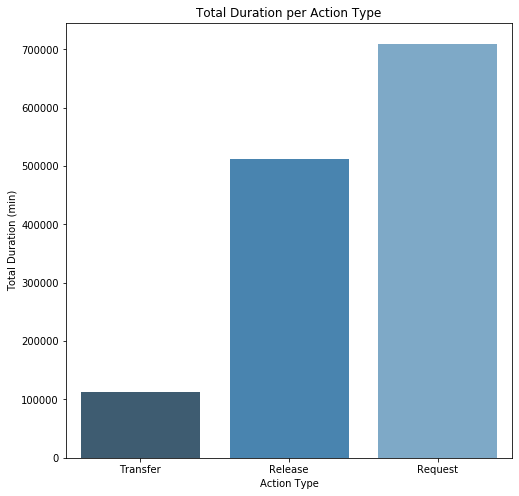

In [24]:
plt.figure(figsize = (8, 8))
plt.title('Total Duration per Action Type')
sns.barplot(x = 'Action Type', y = 'Total Duration (min)', data = results, palette = 'Blues_d')

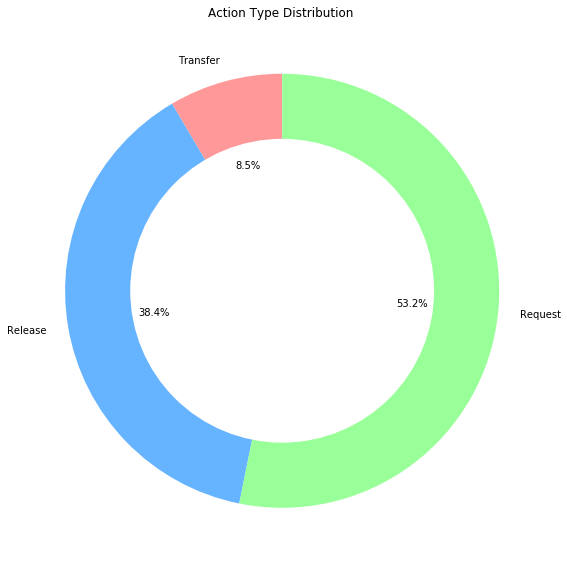

In [25]:
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

fig1, ax1 = plt.subplots(figsize = (8, 8))
ax1.pie(results['Total Duration (min)'], colors = colors, labels = results['Action Type'], autopct='%1.1f%%', startangle=90)
plt.title('Action Type Distribution')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

In [26]:
results.iplot(kind = 'bar', x = 'Action Type', 
              y = 'Total Duration (min)', 
              title = 'Total Duration per Action Type', 
             xTitle = 'Action Type', 
             yTitle = 'Total Duration (min)', color = 'rgba(50, 171, 96, 1.0)')

In [296]:
# Question 2

In [297]:
df.head()

,transaction_id,parent_transaction_id,action,scheduler,surgeon,created_datetime,snapshot_date,start_time,end_time,room_name,location
0,2c91808267d2ea5301682f73e9a1093e,None,RELEASE,Jessie Shelley,Bryan Neer,2019-01-15 13:52:32,2019-07-01 00:00:00.000000,07:30:00,19:00:00,MRAH OR 03,CENTER
1,2c91808267d2ea5301683984e52b0bfb,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:17,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MRAH OR 06,CENTER
2,2c91808267d2ea53016839855a480bfc,None,TRANSFER,Raymond Smith,Charles Mcdonald,2019-01-17 12:47:47,2019-06-20 00:00:00.000000,07:30:00,19:00:00,MNOR 36,CENTER
3,2c91808267d2eb4b016829281a390786,None,RELEASE,Kimberly Bugg,Joann Hinson,2019-01-14 08:32:01,2019-06-12 00:00:00.000000,08:50:00,19:00:00,MNOR 25,CENTER
4,2c91808267d2eb4b01682977274607cb,2c91808267d2eb4b016829281a390786,MARK_UPDATED,Dora Smith,Joann Hinson,2019-01-14 09:58:21,2019-06-12 00:00:00.000000,08:50:00,19:00:00,MNOR 25,CENTER


In [298]:
transferApproval_ID = []
transferDenial_ID = []

for i in range(0, len(Transfer_IDs)):
        
        a = df[df['parent_transaction_id'] == Transfer_IDs[i]]
        
        if len(a[a['action'] == 'APPROVE_TRANSFER']) == 1:
            
            if len(a[a['action'] == 'MARK_UPDATED']) == 1:
                
                index_a = a.index[a['action'] == 'APPROVE_TRANSFER'][0]
                transferApproval_ID.append(index_a)
            
        elif len(a[a['action'] == 'DENY_TRANSFER']) == 1:
                
            index_a = a.index[a['action'] == 'DENY_TRANSFER'][0]
            transferDenial_ID.append(index_a)

In [299]:
totalApprovedTransfers = len(transferApproval_ID)

In [300]:
totalDeniedTransfers = len(transferDenial_ID)

In [301]:
Approval_Rate_Transfers = totalApprovedTransfers / (totalApprovedTransfers + totalDeniedTransfers)

In [302]:
Denial_Rate_Transfers = totalDeniedTransfers / (totalApprovedTransfers + totalDeniedTransfers)

In [303]:
Denial_Rate_Transfers

0.026717557251908396

In [304]:
Approval_Rate_Transfers

0.9732824427480916

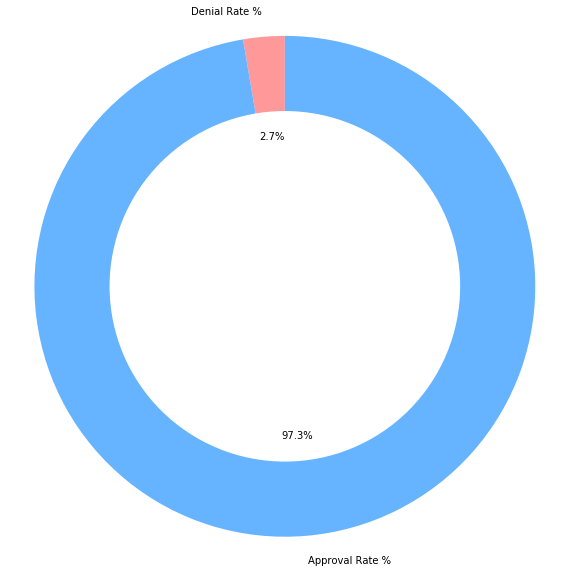

In [305]:
labels = ['Denial Rate %', 'Approval Rate %']

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

fig1, ax1 = plt.subplots(figsize = (8, 8))
ax1.pie([Denial_Rate_Transfers, Approval_Rate_Transfers], labels = labels, colors = colors, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

In [306]:
requestApproval_ID = []
requestDenial_ID = []

for i in range(0, len(Request_IDs)):
        
        a = df[df['parent_transaction_id'] == Request_IDs[i]]
        
        if len(a[a['action'] == 'APPROVE_REQUEST']) == 1:
            
            if len(a[a['action'] == 'MARK_UPDATED']) == 1:
                
                index_a = a.index[a['action'] == 'APPROVE_REQUEST'][0]
                requestApproval_ID.append(index_a)
            
        elif len(a[a['action'] == 'DENY_REQUEST']) == 1:
                
            index_a = a.index[a['action'] == 'DENY_REQUEST'][0]
            requestDenial_ID.append(index_a)

In [307]:
totalApprovedRequests = len(requestApproval_ID)
totalDeniedRequests = len(requestDenial_ID)

Approval_Rate_Requests = totalApprovedRequests / (totalApprovedRequests + totalDeniedRequests)
Denial_Rate_Requests = totalDeniedRequests / (totalApprovedRequests + totalDeniedRequests)

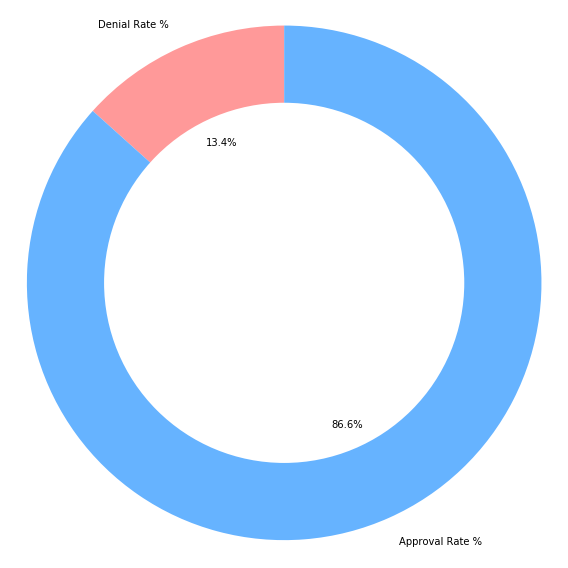

In [308]:
labels = ['Denial Rate %', 'Approval Rate %']

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

fig1, ax1 = plt.subplots(figsize = (8, 8))
ax1.pie([Denial_Rate_Requests, Approval_Rate_Requests], labels = labels, colors = colors, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

In [309]:
responseTimeTransfer = []

In [310]:
for i in range(0, len(Transfer_IDs)):
        
        a = df[df['parent_transaction_id'] == Transfer_IDs[i]]
        
        b = df[df['transaction_id'] == Transfer_IDs[i]]
        index_b = b.index[0]
        
        if len(a[a['action'] == 'APPROVE_TRANSFER']) == 1:
            
            if len(a[a['action'] == 'MARK_UPDATED']) == 1:
                
                index_a = a.index[a['action'] == 'APPROVE_TRANSFER'][0]
                responseTimeTransfer.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])
            
        elif len(a[a['action'] == 'DENY_TRANSFER']) == 1:
                
            index_a = a.index[a['action'] == 'DENY_TRANSFER'][0]
            responseTimeTransfer.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])

In [311]:
for i in range(0, len(responseTimeTransfer)):
    
    responseTimeTransfer[i] = responseTimeTransfer[i].total_seconds()/60

In [312]:
averageResponseTimeTransfer = sum(responseTimeTransfer) / len(responseTimeTransfer)

In [313]:
responseTimeRequest = []

In [314]:
for i in range(0, len(Request_IDs)):
        
        a = df[df['parent_transaction_id'] == Request_IDs[i]]
        
        b = df[df['transaction_id'] == Request_IDs[i]]
        index_b = b.index[0]
        
        if len(a[a['action'] == 'APPROVE_REQUEST']) == 1:
            
            if len(a[a['action'] == 'MARK_UPDATED']) == 1:
                
                index_a = a.index[a['action'] == 'APPROVE_REQUEST'][0]
                responseTimeRequest.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])
            
        elif len(a[a['action'] == 'DENY_REQUEST']) == 1:
                
            index_a = a.index[a['action'] == 'DENY_REQUEST'][0]
            responseTimeRequest.append(a['created_datetime'][index_a] - b['created_datetime'][index_b])

In [315]:
for i in range(0, len(responseTimeRequest)):
    
    responseTimeRequest[i] = responseTimeRequest[i].total_seconds()/60

In [316]:
averageResponseTimeRequest = sum(responseTimeRequest) / len(responseTimeRequest)

<BarContainer object of 2 artists>

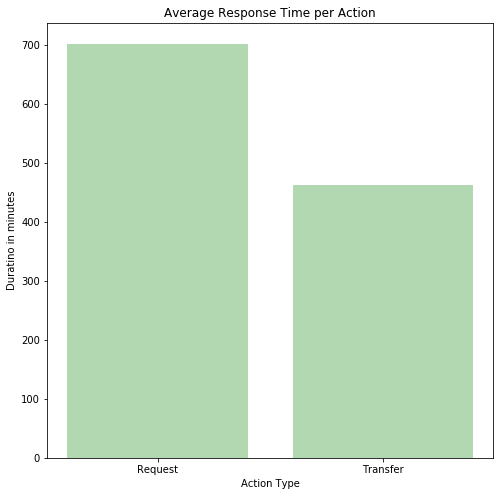

In [317]:
plt.figure(figsize = (8, 8))
plt.title('Average Response Time per Action')
plt.xlabel('Action Type')
plt.ylabel('Duratino in minutes')
plt.bar(x = ['Request', 'Transfer'], 
        height = [averageResponseTimeRequest, 
                  averageResponseTimeTransfer], 
                    color = 'g', alpha = 0.3)